In [83]:
# Use below command to install
# pip install git+https://github.com/jeslago/epftoolbox.git

In [1]:
# extract data
from epftoolbox.data import read_data

In [2]:
from epftoolbox.evaluation import MAE
from epftoolbox.evaluation import RMSE
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE
# calculating rMAE and MASE require naive forecast

In [3]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

2023-04-30 23:22:33.314879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
seq_len=24
n_seq = 3
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [6]:
df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date='01-01-2016',end_test_date='01-02-2016')

Test datasets: 2016-01-01 00:00:00 - 2016-02-01 23:00:00


In [7]:
# train dataset
df_train

,Price,Exogenous 1,Exogenous 2
Date,,,
2013-01-01 00:00:00,25.464211,85049.0,11509.0
2013-01-01 01:00:00,23.554578,82128.0,10942.0
2013-01-01 02:00:00,22.122277,80729.0,10639.0
2013-01-01 03:00:00,21.592066,80248.0,10476.0
2013-01-01 04:00:00,21.546501,80850.0,10445.0
...,...,...,...
2015-12-31 19:00:00,29.513832,100700.0,13015.0
2015-12-31 20:00:00,28.440134,99832.0,12858.0
2015-12-31 21:00:00,26.701700,97033.0,12626.0


In [8]:
date = df_train.index

In [9]:
price = df_train['Price']

In [10]:
price

Date
2013-01-01 00:00:00    25.464211
2013-01-01 01:00:00    23.554578
2013-01-01 02:00:00    22.122277
2013-01-01 03:00:00    21.592066
2013-01-01 04:00:00    21.546501
                         ...    
2015-12-31 19:00:00    29.513832
2015-12-31 20:00:00    28.440134
2015-12-31 21:00:00    26.701700
2015-12-31 22:00:00    23.262253
2015-12-31 23:00:00    22.262431
Name: Price, Length: 26280, dtype: float64

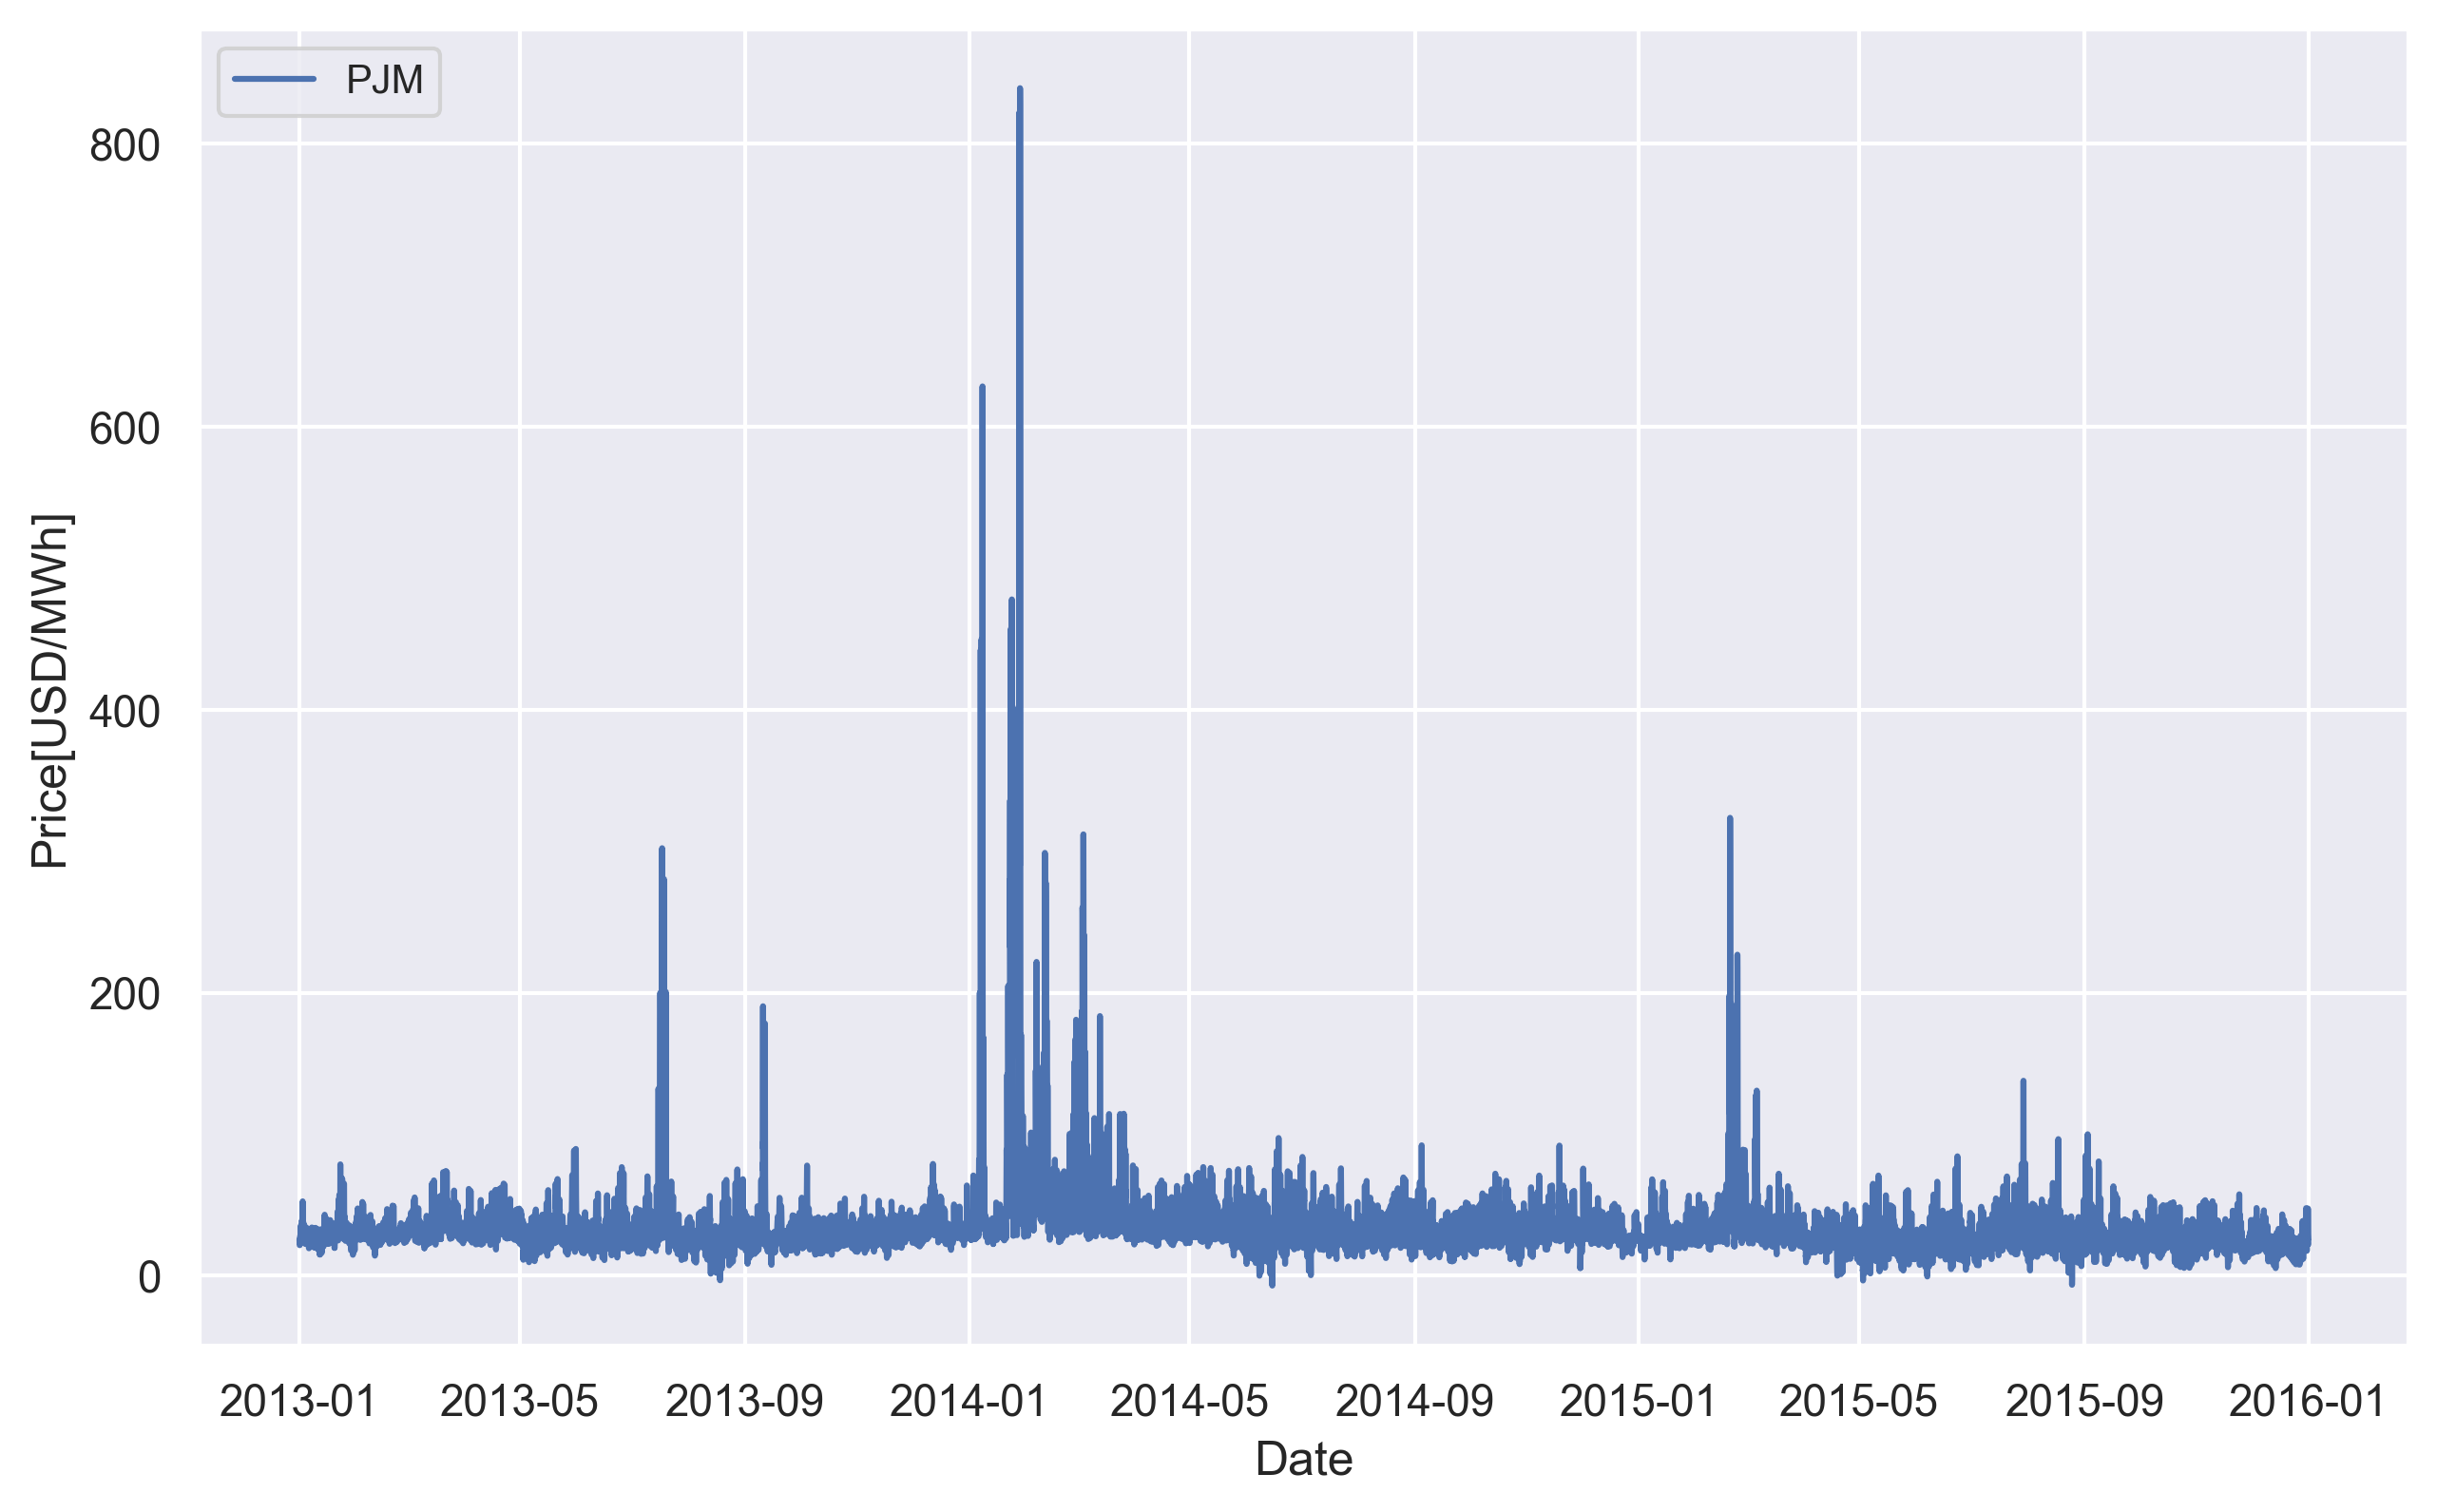

In [117]:
import seaborn as sns
sns.set()
#figu, ax = plt.subplots(nrows =1, ncols=1, figsize = (10,6))
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (10,6))
plt.plot(price)

plt.legend(loc = 'upper left',fontsize = 'small',labels=["PJM"])
plt.xlabel("Date")
plt.ylabel("Price[USD/MWh]")
plt.show()

In [12]:
print(df_train.shape)
print(df_test.shape)


(26280, 3)
(768, 3)


In [13]:
elect_data = processed_stock(path='../AMS 522/PJM.csv', seq_len=seq_len)
print(len(elect_data),elect_data[0].shape)

52392 (24, 3)


In [14]:
if path.exists('synthesizer_PJM.pkl'):
    synth = TimeGAN.load('synthesizer_PJM.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(elect_data, train_steps=50000)
    synth.save('synthesizer_PJM.pkl')

2023-04-30 23:22:41.708299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
synth_data = synth.sample(len(elect_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 410/410 [01:26<00:00,  4.74it/s]

(52480, 24, 3)


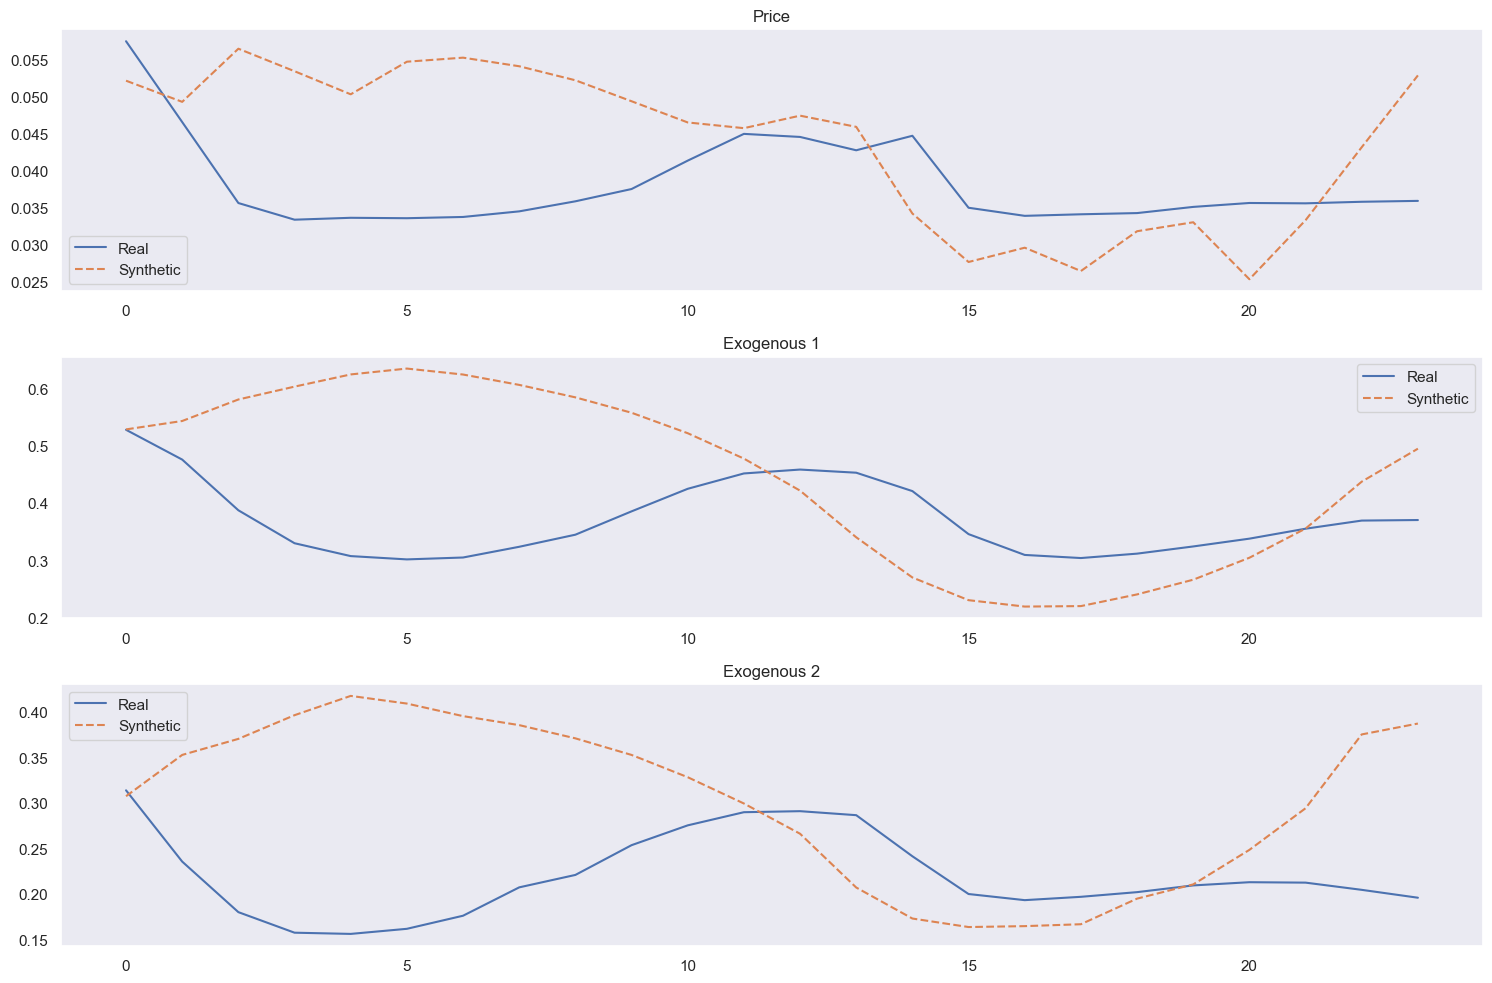

In [16]:
#Reshaping the data
cols = ['Price','Exogenous 1','Exogenous 2']
# zonal prices in commonwealth edison(COMED) (zone located in the state of Illinois)
# 2 day ahead load forecast series, one describes the system load and the second one the COMED zonal load   

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
# generate random number up to the length of elect_data(my data)
obs = np.random.randint(len(elect_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': elect_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(elect_data))[:sample_size]

real_sample = np.asarray(elect_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

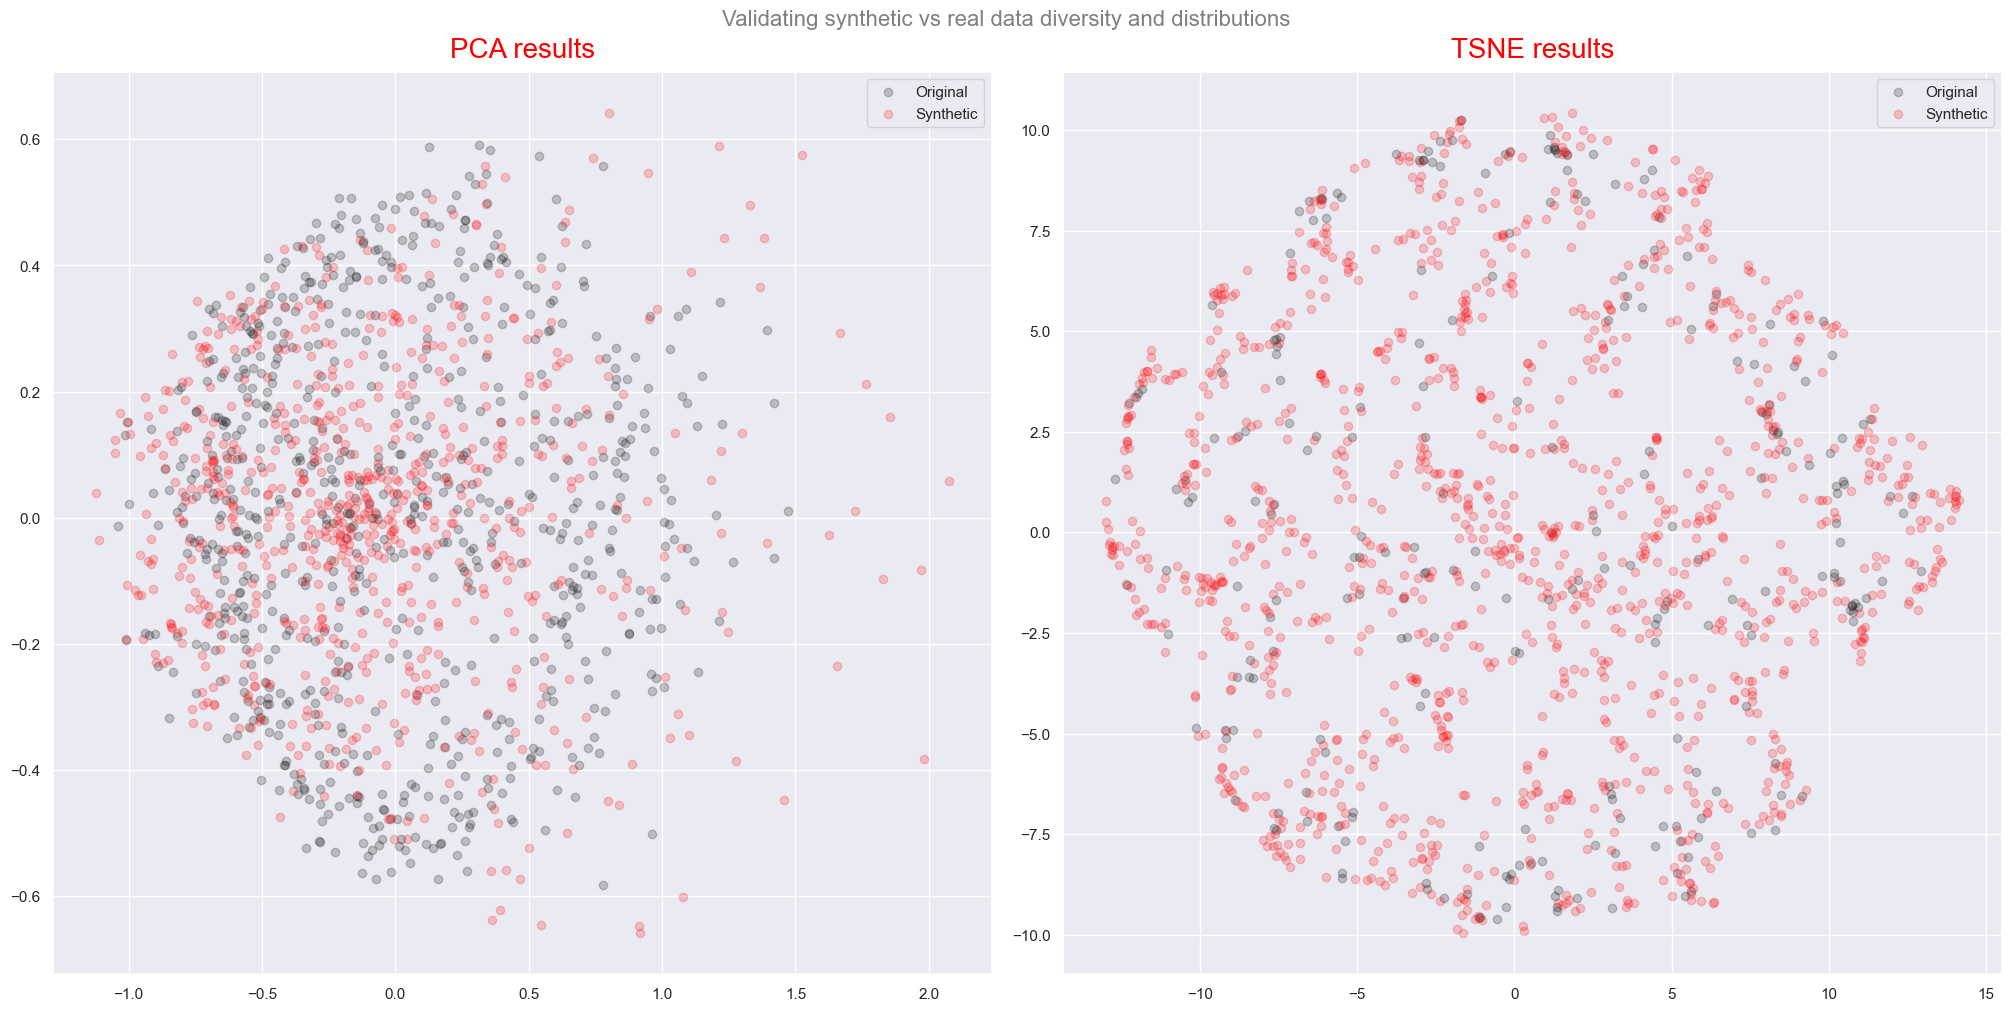

In [18]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [19]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=3,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [20]:
#Prepare the dataset for the regression model
elect_data=np.asarray(elect_data)
synth_data = synth_data[:len(elect_data)]
n_events = len(elect_data)

In [21]:
#Split data on train and test
idx = np.arange(n_events)
n_train = int(.7503435639*n_events)
train_idx = idx[:n_train+1]
test_idx = idx[n_train+1:]

In [22]:
#Define the X for synthetic and real data
X_stock_train = elect_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

#Define the y for synthetic and real datasets
y_stock_train = elect_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

#test set
X_stock_test = elect_data[test_idx, :seq_len-1, :]
y_stock_test = elect_data[test_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (39312, 23, 3)
Real X train: (39312, 23, 3)
Synthetic y train: (39312, 3)
Real y train: (39312, 3)
Real X test: (13080, 23, 3)
Real y test: (13080, 3)


In [90]:
X_stock_train2 = elect_data[train_idx,-1, :]
X_synth_train2 = synth_data[train_idx,-1,:]

In [88]:
X_stock_train2.shape

(39312, 3)

In [91]:
X_stock_train2

array([[0.03423098, 0.14480695, 0.07644077],
       [0.04852524, 0.59922238, 0.29128869],
       [0.04517721, 0.30351441, 0.17742796],
       ...,
       [0.04601804, 0.51190104, 0.35458911],
       [0.04147373, 0.39139982, 0.46471451],
       [0.0583702 , 0.56945718, 0.58537887]])

In [23]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 4s 8ms/step - loss: 0.1191 - val_loss: 0.0674
Epoch 2/200
308/308 [==============================] - 2s 8ms/step - loss: 0.0469 - val_loss: 0.0358


In [24]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
308/308 [==============================] - 4s 8ms/step - loss: 0.1231 - val_loss: 0.0701
Epoch 2/200
308/308 [==============================] - 2s 7ms/step - loss: 0.0545 - val_loss: 0.0361


In [25]:
# predictions
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

409/409 [==============================] - 1s 1ms/step


In [39]:
# take only price data
real_predictions

array([[0.03849267, 0.50953996, 0.41977966],
       [0.05166771, 0.24755527, 0.19454068],
       [0.0382284 , 0.4088621 , 0.33545986],
       ...,
       [0.05189699, 0.2718964 , 0.22017084],
       [0.04001286, 0.3032229 , 0.23415972],
       [0.03776389, 0.2741681 , 0.22269514]], dtype=float32)

In [38]:
# price array for real_prediction
r_pred = real_predictions.flatten()
re_pred = r_pred[0:len(r_pred):3]

In [72]:
re_pred.shape

(13080,)

In [43]:
# price array for synthetic data
s_pred = synth_predictions.flatten()
sy_pred = s_pred[0:len(s_pred):3]

In [73]:
sy_pred.shape

(13080,)

In [46]:
y_stock_test

array([[0.05987361, 0.48735357, 0.37780149],
       [0.03194922, 0.2370539 , 0.20951174],
       [0.06556025, 0.41985556, 0.32950907],
       ...,
       [0.03224865, 0.25033996, 0.17662753],
       [0.03712333, 0.38598064, 0.26400747],
       [0.04193148, 0.32151455, 0.24052828]])

In [52]:
# price data for y_stock_test
y_st = y_stock_test.flatten()
y_stock = y_st[0:len(y_st):3]
y_stock[:10]

array([0.05987361, 0.03194922, 0.06556025, 0.0484647 , 0.03917719,
       0.03324923, 0.03850657, 0.04602938, 0.03295864, 0.04025074])

In [97]:
y_stock_train

array([[0.03423098, 0.14480695, 0.07644077],
       [0.04852524, 0.59922238, 0.29128869],
       [0.04517721, 0.30351441, 0.17742796],
       ...,
       [0.04601804, 0.51190104, 0.35458911],
       [0.04147373, 0.39139982, 0.46471451],
       [0.0583702 , 0.56945718, 0.58537887]])

In [102]:
y_s = y_stock_train.flatten()
y_ss = y_s[0:len(y_stock_train):3]

In [ ]:
# MASE in-sample data check on it

In [93]:
#Summarize the metrics here as a pandas dataframe
metrics_dict = {'MAE': [MAE(y_stock, re_pred),
                        MAE(y_stock, sy_pred)],
                'rMAE':[rMAE(y_stock, re_pred, m ='D',freq='1H'),
                        rMAE(y_stock, sy_pred,m='D',freq='1H')],
                'MAPE':[MAPE(y_stock, re_pred),
                       MAPE(y_stock, sy_pred)],
                'sMAPE':[sMAPE(y_stock, re_pred),
                        sMAPE(y_stock, sy_pred)],
                'MASE': [MASE(y_stock, re_pred, X_stock_train2,m='D',freq='1H'),
                         MASE(y_stock, sy_pred, X_synth_train2,m='D',freq='1H')],
               'RMSE':[RMSE(y_stock,re_pred),
                      RMSE(y_stock, sy_pred)]
               }

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results


,MAE,rMAE,MAPE,sMAPE,MASE,RMSE
Real,0.014623,0.901280,0.350494,0.319406,0.123017,0.024169
Synthetic,0.009674,0.596264,0.206310,0.201572,0.079986,0.018593


In [104]:
y_stock

array([0.05987361, 0.03194922, 0.06556025, ..., 0.03224865, 0.03712333,
       0.04193148])

In [ ]:
figu, ax = plt.subplots(nrows =1, ncols=2, figsize = (10,6))
figu.plot(ystock)

plt.legend(loc = 'upper left',fontsize = 'small',labels=["PJM"])
plt.xlabel("Date")
plt.ylabel("Price[USD/MWh]")
plt.show()

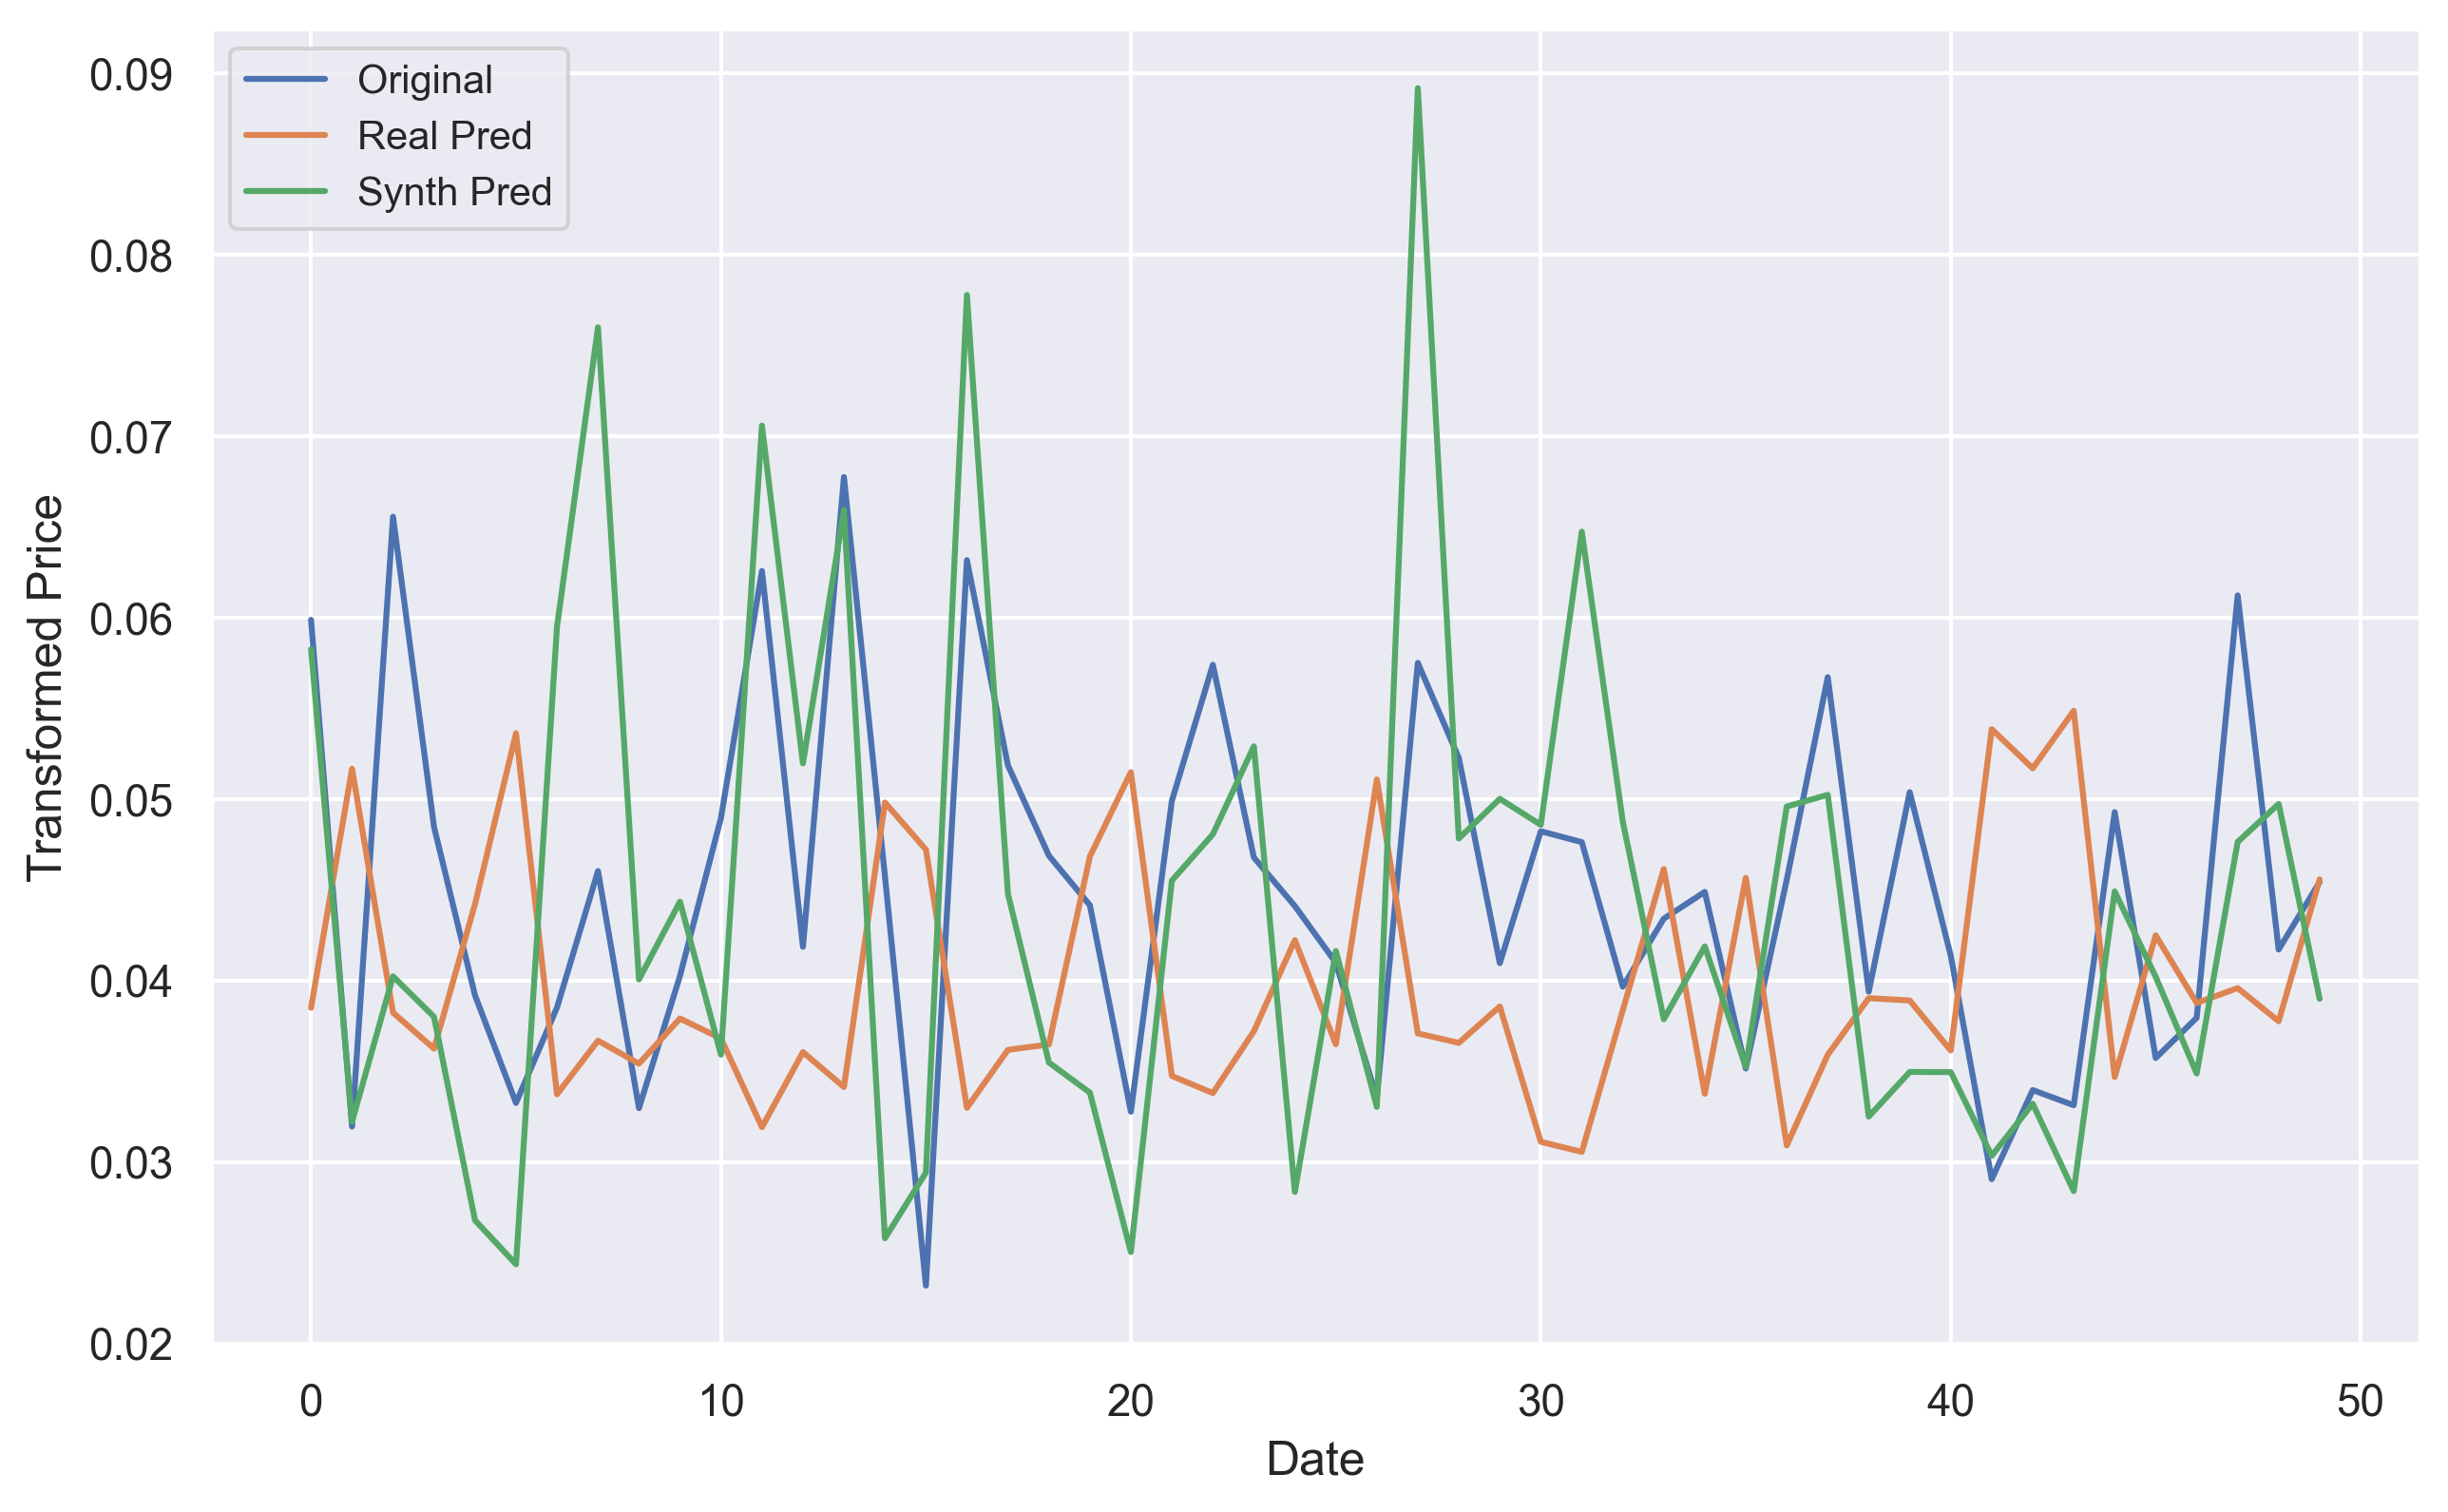

In [116]:
#figu, ax = plt.subplots(nrows =1, ncols=1, figsize = (10,6))
plt.rcParams['figure.dpi'] = 300

plt.figure(figsize = (10,6))
plt.plot(y_stock[:50])
plt.plot(re_pred[:50])
plt.plot(sy_pred[:50])


plt.legend(loc = 'upper left',fontsize = 'small',labels=["Original","Real Pred", "Synth Pred"])
plt.xlabel("Date")
plt.ylabel("Transformed Price")
plt.show()

In [130]:
from terminaltables import AsciiTable
data = [['Metrics','Best DNN', 'Best LEAR', 'TimeGAN Real', 'TimeGAN Synth'],['rMAE',0.486,0.489,0.90128,0.5962], ['MAE',3.075,3.095,0.014623,0.009674 ],['MAPE [%]',27.975,30.239,0.3504*100,20.63],['sMAPE [%]',12.004,12.538,0.3194*100,0.201572*100],['MASE','N/A','N/A',0.123017,0.079986],['RMSE', 5.498,5.142,0.02416,0.0185 ]]

In [131]:
table = AsciiTable(data, title='PJM')
table.justify = 'center'
table.inner_row_border = True
print(table.table)

+PJM--------+----------+-----------+--------------+---------------+
| Metrics   | Best DNN | Best LEAR | TimeGAN Real | TimeGAN Synth |
+-----------+----------+-----------+--------------+---------------+
| rMAE      | 0.486    | 0.489     | 0.90128      | 0.5962        |
+-----------+----------+-----------+--------------+---------------+
| MAE       | 3.075    | 3.095     | 0.014623     | 0.009674      |
+-----------+----------+-----------+--------------+---------------+
| MAPE [%]  | 27.975   | 30.239    | 35.04        | 20.63         |
+-----------+----------+-----------+--------------+---------------+
| sMAPE [%] | 12.004   | 12.538    | 31.94        | 20.1572       |
+-----------+----------+-----------+--------------+---------------+
| MASE      | N/A      | N/A       | 0.123017     | 0.079986      |
+-----------+----------+-----------+--------------+---------------+
| RMSE      | 5.498    | 5.142     | 0.02416      | 0.0185        |
+-----------+----------+-----------+------------